In [1]:
import inv_mcmc
import numpy as np
from data import Data
from yang import Yang
from mogi import Mogi
from penny import Penny
from okada import Okada
import corner
import matplotlib.pyplot as plt
import pymc

Reduced
[-0.0906611  0.        -0.0002376 -0.0155113  0.0074772  0.
  0.0664302 -0.0237102  0.0944397  0.         0.0773218  0.0105368]
-4970.4289589995215 1540.7391562484627 -0.0906611 0.007477200000000001
11956.510456745487 -188.609004887192 0.0 0.0
-2270.968863899415 4865.5125529444485 -0.0002376 0.0664302
-4715.11263384655 -6217.6427043057265 -0.015511299999999999 -0.0237102


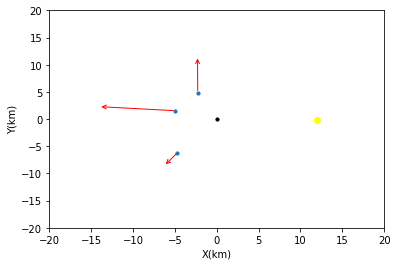

In [4]:
#Reference station index
#Makushin
#refidx=4

#Okmok
refidx=1

#Generating random x and y positions for the gps stations
#ran=np.random.uniform(-10*1e3, 10*1e3, size=(n,2))
#Makushin
#x=[-61958.77076613814, -49301.01672239235, -51777.0034892224, -35640.97720852007, -36053.391886423095]
#x=x-np.mean(x)
#print(x)
#y=[90345.09359133619, 90362.8632146412, 102089.25230327141, 97591.72582247354, 100865.20643234088]
#y=y-np.mean(y)
#print(y)

#Okmok
x=[-11045.287433254254, 5881.651982490754, -8345.827338154148, -10789.971108101283]
x=x-np.mean(x)
y=[47441.121814943406, 45711.77365380775, 50765.89521163939, 39682.73995438922]
y=y-np.mean(y)

#Function to generate a noisy yang model
def yang_noisy_model(xcen,ycen,z0,dP,a,b,phi,dip):
    #create data structure
    dat = Data()
    dat.add_locs(x,y)
    yan = Yang(dat)
    ux,uy,uz=yan.forward(xcen=xcen,ycen=ycen,z0=z0,P=dP,a=a,b=b,phi=phi,theta=dip,mu=9.6e9)
    
    ux+=0.5*np.abs(ux)*np.random.uniform(-1,1,len(ux))
    uy+=0.5*np.abs(uy)*np.random.uniform(-1,1,len(uy))
    uz+=0.5*np.abs(uz)*np.random.uniform(-1,1,len(uz))
    
    return ux,uy,uz

#Makushin
#Get noisy displacements on the gps stations due to the Yang model
#ux=[-5.954,-3.8092,0.8392,-3.3574,-3.2916]
#ux=np.array(ux)/1000
#uy=[-3.6423,-4.385,0.7758,-1.2003,-0.7533]
#uy=np.array(uy)/1000
#uz=[7.6583,8.1346,7.8789,4.3791,5.3724]
#ux,uy,uz=yang_noisy_model(0,0,3e3,5e8,1e3,5e2,60,30)
#uz=np.array(uz)/1000

#Okmok
#ux=[-17.262571072788894, 0.4094056737991875, -0.3045515895501605, -1.241065477874462]
#ux=[-17.89085928298953, 0.3847686171658675, -0.24499000078109606, -1.3608901083925842]
#ux=[-12.13472,0,-1.65196,0]
ux=[-9.06611,0,-0.02376,-1.55113]
ux=np.array(ux)/100
#uy=[-0.7299148029496431, -1.9743634646765105, 11.801463782734485, -5.117206974270814]
#uy=[-0.3302984527024676, -1.8163848084088023, 12.705278235672136, -4.758886900946369]
#uy=[0.90093,0,10.06750,0]
uy=[0.74772,0,6.64302,-2.37102]
uy=np.array(uy)/100
#uz=[20.38637344845071, -1.241475315667577, 14.686097590317281, 0.2064070409583689]
#uz=[20.64072871838956, -0.522671924819897, 14.713492519216675, 0.17289147679317232]
#uz=[0,0,0,0]
uz=[9.44397,0,7.73218,1.05368]
uz=np.array(uz)/100
#ux,uy,uz=yang_noisy_model(0,0,3e3,5e8,1e3,5e2,60,30)

#Creating the Data object for the observations
obs=Data('gps')
obs.add_locs(x,y)
obs.add_disp(ux,uy,uz)
obs.set_refidx(refidx)

#Input data for the inversion (deformation reduced with respect to the reference station)
data=obs.get_obs()
wts=np.ones(data.shape)
#wts[8:12]=0
print(data)
iux,iuy,iuz=obs.get_reduced_obs()

#Plot of the gps vectors
plt.figure()
plt.scatter(x/1e3,y/1e3,s=10)
plt.scatter(x[refidx]/1e3,y[refidx]/1e3,c='yellow')
plt.scatter(0,0,s=10,c='black')
scale=100
for i in range(len(x)):
    print(x[i],y[i],ux[i],uy[i])
    plt.annotate("", xy=(x[i]/1e3+iux[i]*scale, y[i]/1e3+iuy[i]*scale), xytext=(x[i]/1e3, y[i]/1e3),arrowprops=dict(arrowstyle="->",color="red"))
plt.ylim(-20,20)
plt.xlim(-20,20)
plt.ylabel('Y(km)')
plt.xlabel('X(km)')

plt.show()

In [5]:
#Creating the Data object for the postions of the stations on every model
dat = Data('gps')
dat.add_locs(x,y)
dat.set_refidx(refidx)

#Yang model 
yang=Yang(dat)
#Initial parameters [xcen,ycen,depth,pressure,semimajor axis,semimenor axis,strike,dip]
yang.set_x0(np.array([2000,2000,1e3,8.5e8,1e3,5e2,20,20]))
#Bounds for parameters [xcen,ycen,depth,pressure,semimajor axis,semimenor axis,strike,dip]
yang.set_bounds(low_bounds  = [-10000, -10000, 0, 1e8,     100,     100,  10, 0], 
                high_bounds = [ 10000,  10000, 40000,  1e9, 20000, 20000, 70, 360])

#Mogi model
mogi = Mogi(dat)
#Initial parameters [xcen,ycen,depth,volume change]
mogi.set_x0(np.array([0, 0, 2000, 1e6]))
#Bounds for parameters [xcen,ycen,depth,volume change]
mogi.set_bounds(low_bounds = [-7000, -7000, 200, 0.1], high_bounds = [2000, 2000, 20000, 5e7])

#Penny shaped crack model
penny = Penny(dat)
#Initial parameters [xcen,ycen,depth,pressure(shear),radius]
penny.set_x0(np.array([0, 0, 500, 0.01, 1000]))
#Bounds for parameters [xcen,ycen,depth,pressure(shear),radius]
penny.set_bounds(low_bounds = [-10000, -10000, 0, -10, 0], high_bounds = [10000, 10000, 40000, 100, 10000])

#Okada model
okada = Okada(dat)
#Defining type two options (open,slip)
okada.set_type('open')
#Initial parameters [xcen,ycen,depth,length,width,opening,strike,dip]
okada.set_x0(np.array([0, 0, 1e3, 1e3, 1e3,10.0,1.0,1.0]))
#Bounds for parameters [xcen,ycen,depth,length,width,opening,strike,dip]
okada.set_bounds(low_bounds = [-10000, -10000, 0, 0, 0, 0, 0, 0], high_bounds = [10000, 10000, 10000, 10000, 10000,50.0,360.0,90.0])

#Inversion using in this case Mogi model
#trace,MDL=inv_mcmc.inversion(mogi,data)
trace,MDL=inv_mcmc.inversion(mogi,data,wts=wts)

 [-----------------100%-----------------] 1100000 of 1100000 complete in 361.6 sec

Plotting sigma
Plotting depth
Plotting ycen
Plotting xcen
Plotting dV


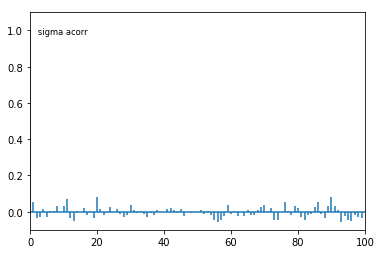

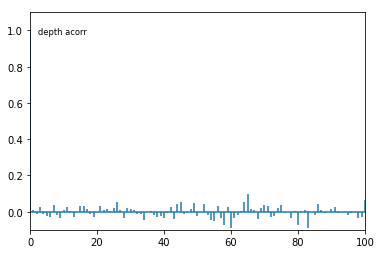

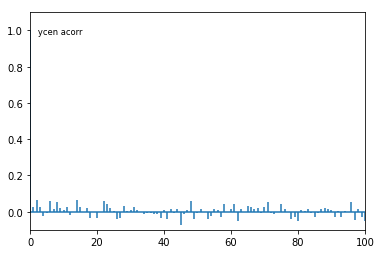

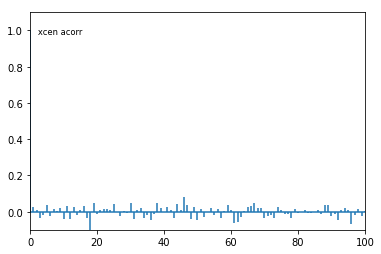

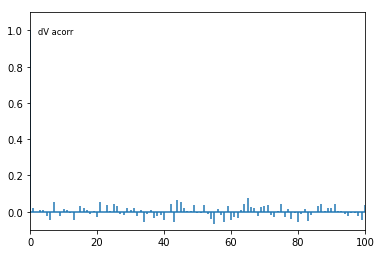

In [4]:
#Autocorrelation plots
pymc.Matplot.autocorrelation(MDL)

1090
1090
1090
1090


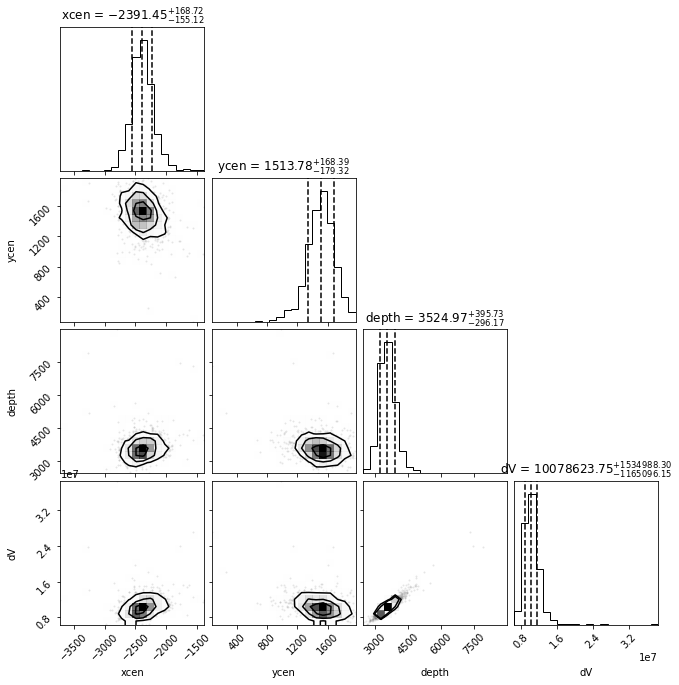

In [6]:
data=[]
labels=[]
parnames=mogi.get_parnames()
orders=mogi.get_orders()
for i,tr in enumerate(trace):
    print(len(tr[:]))
    data.append(tr[:]*orders[i])
    labels.append(parnames[i])
data=np.vstack(data)
figure = corner.corner(data.T, labels=labels,
                       quantiles=[0.16, 0.5, 0.84],
                       show_titles=True, title_kwargs={"fontsize": 12})
plt.savefig('histograms')

[-0.07446903  0.01049503  0.00250747 -0.00817959] [ 0.00077197 -0.00124544  0.07001364 -0.02721111] [0.101768   0.00257849 0.07363782 0.01240605]


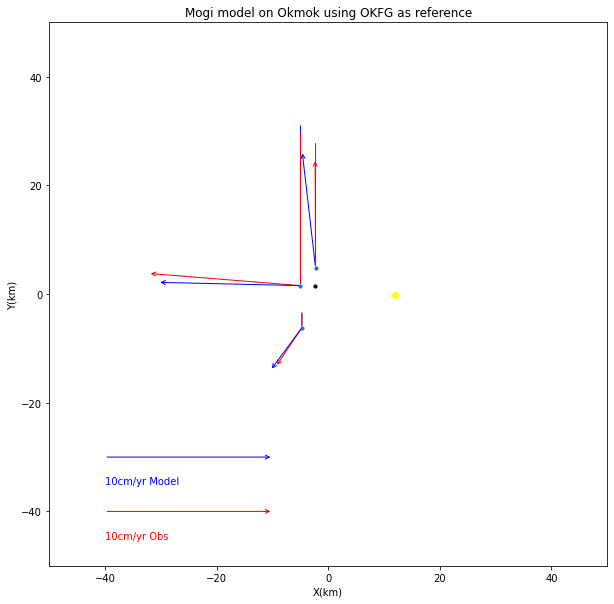

In [26]:
#rux,ruy,ruz=mogi.gps(-1807,1438,314,4835762)
rux,ruy,ruz=mogi.gps(-2391,1514,3525,10078624)
print(rux,ruy,ruz)
rux-=rux[refidx]
ruy-=ruy[refidx]
ruz-=ruz[refidx]

plt.figure(figsize=(10,10))
plt.title('Mogi model on Okmok using OKFG as reference')
plt.scatter(x/1e3,y/1e3,s=10)
plt.scatter(x[refidx]/1e3,y[refidx]/1e3,c='yellow')
plt.scatter(-2391/1e3,1514/1e3,s=10,c='black')
scale=300
for i in range(len(x)):
    #print(x[i],y[i],ux[i],uy[i])
    plt.annotate("", xy=(x[i]/1e3+iux[i]*scale, y[i]/1e3+iuy[i]*scale), xytext=(x[i]/1e3, y[i]/1e3),arrowprops=dict(arrowstyle="->",color="red"))
    plt.annotate("", xy=(x[i]/1e3+rux[i]*scale, y[i]/1e3+ruy[i]*scale), xytext=(x[i]/1e3, y[i]/1e3),arrowprops=dict(arrowstyle="->",color="blue"))
    plt.annotate("", xy=(x[i]/1e3, y[i]/1e3+ruz[i]*scale), xytext=(x[i]/1e3, y[i]/1e3),arrowprops=dict(arrowstyle="-",color="blue"))
    plt.annotate("", xy=(x[i]/1e3, y[i]/1e3+iuz[i]*scale), xytext=(x[i]/1e3, y[i]/1e3),arrowprops=dict(arrowstyle="-",color="red"),alpha=0)
    
plt.ylim(-50,50)
plt.xlim(-50,50)

plt.annotate("", xy=(-40+0.1*scale, -40), xytext=(-40, -40),arrowprops=dict(arrowstyle="->",color="red"))
plt.annotate(r"10cm/yr Obs", xy=(-40, -45), xytext=(-40, -45),color='red')

plt.annotate("", xy=(-40+0.1*scale, -30), xytext=(-40, -30),arrowprops=dict(arrowstyle="->",color="blue"))
plt.annotate(r"10cm/yr Model", xy=(-40, -35), xytext=(-40, -35),color='blue')

plt.ylabel('Y(km)')
plt.xlabel('X(km)')

plt.show()

[-0.00569705  0.          0.00774996  0.00316332] [ 0.00545979  0.         -0.00482888  0.00225548] [-0.00474981  0.          0.00626247  0.00070924]


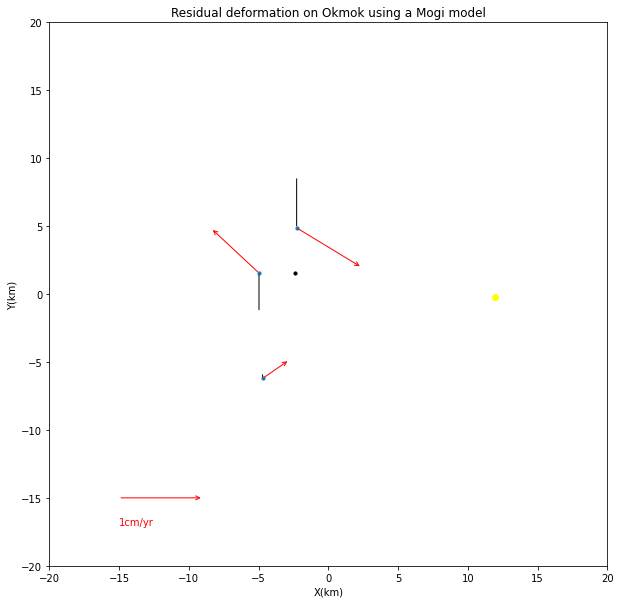

In [29]:
print(iux-rux,iuy-ruy,iuz-ruz)

plt.figure(figsize=(10,10))
plt.title('Residual deformation on Okmok using a Mogi model')
plt.scatter(x/1e3,y/1e3,s=10)
plt.scatter(x[refidx]/1e3,y[refidx]/1e3,c='yellow')
plt.scatter(-2391/1e3,1514/1e3,s=10,c='black')
scale=600
for i in range(len(x)):
    #print(x[i],y[i],ux[i],uy[i])
    plt.annotate("", xy=(x[i]/1e3+(iux[i]-rux[i])*scale, y[i]/1e3+(iuy[i]-ruy[i])*scale), xytext=(x[i]/1e3, y[i]/1e3),arrowprops=dict(arrowstyle="->",color="red"))
    plt.annotate("", xy=(x[i]/1e3, y[i]/1e3+(iuz[i]-ruz[i])*scale), xytext=(x[i]/1e3, y[i]/1e3),arrowprops=dict(arrowstyle="-",color="black"))
    #plt.annotate("", xy=(x[i]/1e3+rux[i]*scale, y[i]/1e3+ruy[i]*scale), xytext=(x[i]/1e3, y[i]/1e3),arrowprops=dict(arrowstyle="->",color="blue"))
plt.ylim(-20,20)
plt.xlim(-20,20)

plt.annotate("", xy=(-15+0.01*scale, -15), xytext=(-15, -15),arrowprops=dict(arrowstyle="->",color="red"))
plt.annotate(r"1cm/yr", xy=(-15, -17), xytext=(-15, -17),color='red')

#plt.annotate("", xy=(-40+0.01*scale, -30), xytext=(-40, -30),arrowprops=dict(arrowstyle="->",color="blue"))
#plt.annotate(r"1cm/yr Model", xy=(-40, -35), xytext=(-40, -35),color='blue')

plt.ylabel('Y(km)')
plt.xlabel('X(km)')

plt.show()